In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Explore data

In [3]:
PATH = 'data'

In [4]:
!ls {PATH}

labels.csv  models  pred_probs.csv  sample_submission.csv  test  tmp  train


In [5]:
!ls {PATH}/train | wc -l
!ls {PATH}/test | wc -l

10222
10357


In [6]:
labels = pd.read_csv(f'{PATH}/labels.csv')
labels.shape

(10222, 2)

In [7]:
labels['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
blenheim_spaniel                  102
miniature_pinscher                102
australian_terrier                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
whippet                            95
siberian_husky                     95
norwegian_elkhound                 95
pug         

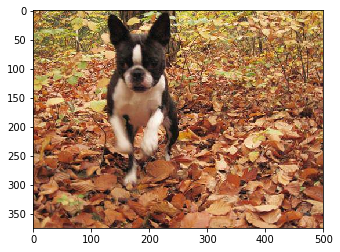

In [8]:
sample_files = !ls {PATH}/train | head
img = plt.imread(f'{PATH}/train/{sample_files[0]}')
plt.imshow(img)

In [9]:
# Split into training and validation sets
val_idxs = get_cv_idxs(len(labels))
val_idxs.shape

(2044,)

## Model

In [10]:
arch = resnext101_64
sz = 224
bs = 64

### Load data with data augmentation enabled

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [12]:
data = ImageClassifierData.from_csv(
    path=PATH,
    folder='train',
    csv_fname=f'{PATH}/labels.csv',
    bs=bs,
    tfms=tfms,
    val_idxs=val_idxs,
    suffix='.jpg',
    test_name='test')

In [13]:
data.trn_ds.n, data.val_ds.n, data.test_ds.n, data.c

(8178, 2044, 10357, 120)

### Initial model with precomputed activations

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [05:02<00:00,  1.87s/it]


### Pick a learning rate

In [15]:
lrf = learn.lr_find()

A Jupyter Widget

 85%|████████▌ | 109/128 [00:01<00:00, 70.28it/s, loss=12]  


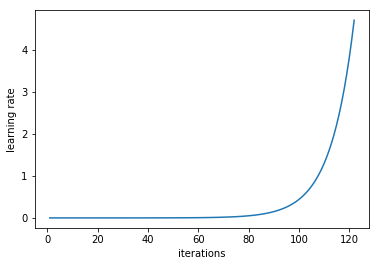

In [16]:
learn.sched.plot_lr()

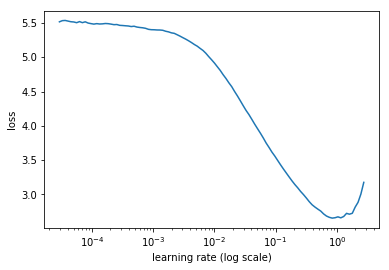

In [17]:
learn.sched.plot()

In [18]:
lr = 0.01

### Train with precomputed activations

In [19]:
learn.fit(lrs=lr, n_cycle=2, cycle_len=1)

A Jupyter Widget

[ 0.       0.98379  0.54419  0.90936]                        
[ 1.       0.54288  0.34388  0.92377]                         



### Train with data augmentation and without precomputed activations

In [19]:
learn.precompute=False

In [21]:
learn.fit(lrs=lr, n_cycle=3, cycle_len=1)

A Jupyter Widget

[ 0.       0.45591  0.2866   0.92809]                        
[ 1.       0.40653  0.25805  0.9345 ]                        
[ 2.       0.35282  0.24223  0.93639]                        



In [18]:
# Decrease learning rate across multiple cycles
learn.fit(lrs=lr, n_cycle=3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.29119  0.23597  0.93646]                        
[ 1.       0.29142  0.22557  0.93444]                        
[ 2.       0.25263  0.22165  0.93493]                        
[ 3.       0.25504  0.22181  0.9335 ]                        
[ 4.       0.22457  0.21397  0.93792]                        
[ 5.       0.20142  0.21516  0.93688]                        
[ 6.       0.19533  0.21318  0.93789]                        



In [19]:
learn.save('dog_breed_resnext')

In [20]:
learn.load('dog_breed_resnext')

### Predict on the test set

In [23]:
# log_preds = learn.predict(is_test=True)
log_preds, _ = learn.TTA(is_test=True)

In [24]:
# Generate class predictions and convert log probabilities
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)

In [25]:
# Sanity check
len(np.unique(preds)), probs.sum(axis=1).mean()

(120, 0.96155691)

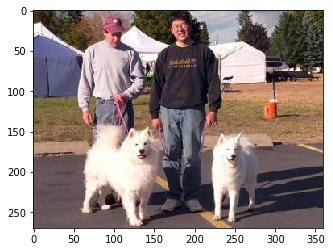

In [31]:
# Check a prediction (of Samoyed!)
class_id_samoyed = np.where(np.array(data.classes) == 'samoyed')[0][0]
file_id_samoyed = np.where(preds == class_id_samoyed)[0][0]

test_fns = data.test_dl.dataset.fnames
img = plt.imread(f'{PATH}/{test_fns[file_id_samoyed]}')
plt.imshow(img)

### Output for submission

In [32]:
probs = pd.DataFrame(probs)
probs.columns = data.classes

test_fns = [re.split('/|\.', fn) for fn in test_fns]
test_ids = [fn[1] for fn in test_fns]

probs['id'] = test_ids

columns = list(probs)
columns.insert(0, columns.pop(columns.index('id')))

probs = probs[columns]
probs.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,fd1a7be32f10493735555e62913c0841,1.992525e-05,6.402575e-05,1.743292e-06,4.787847e-06,4.309323e-06,8.615532e-07,3.290300e-06,3.013403e-06,6.527600e-06,...,7.148203e-05,2.034915e-06,5.258120e-06,3.785119e-06,5.099748e-06,2.021803e-06,9.579279e-06,9.280594e-07,1.681072e-05,1.997227e-06
1,5273d42f02b4715cb93845205995ef64,3.193277e-06,1.103711e-05,1.984114e-05,8.909422e-05,9.958068e-07,1.478069e-06,1.838252e-06,1.791992e-06,8.204855e-07,...,2.521881e-07,2.822514e-08,2.409466e-05,1.037504e-06,2.934477e-06,3.198154e-06,2.689360e-06,5.016721e-06,2.887024e-06,1.472023e-06
2,442057a3142f4d75a1023db363e2fb54,3.565089e-07,8.526860e-07,2.848554e-07,1.860039e-06,6.179300e-08,1.665061e-06,6.816106e-08,7.695057e-07,2.429289e-06,...,8.957369e-07,2.603515e-06,4.060012e-06,2.148346e-05,5.403270e-07,1.341005e-07,5.593534e-07,3.963003e-07,1.084368e-07,1.917747e-07
3,fb03302b030afd122e0f4936c158f6c1,3.150783e-03,6.497744e-06,3.925761e-06,5.722679e-06,8.886574e-06,1.975578e-06,1.828528e-05,1.073962e-05,2.439376e-05,...,3.460739e-04,1.721566e-05,1.530316e-05,1.146648e-06,5.956436e-06,1.913770e-06,5.384559e-06,4.074413e-06,4.615837e-06,2.217407e-03
4,511ca6e3539192aa5c8747bb697e0525,9.349908e-08,3.764807e-08,9.161605e-07,4.337476e-08,1.389112e-07,2.248531e-07,7.560134e-06,1.146151e-07,5.247145e-08,...,4.659925e-06,1.614202e-06,3.045340e-07,4.933429e-09,1.410777e-06,1.711746e-07,2.230083e-06,1.571071e-07,7.273759e-07,8.494431e-06


In [33]:
probs.to_csv(f'{PATH}/pred_probs.csv', index=False)

### Analyze prediction results on the validation set

In [42]:
log_preds_val, _ = learn.TTA()

In [43]:
preds_val = np.argmax(log_preds_val, axis=1)
probs_val = np.exp(log_preds_val)

In [55]:
# Combine with actual labels
pred_vs_act_val = pd.DataFrame({'actual_y': data.val_y, 'predicted_y': preds_val})
pred_vs_act_val['actual_label'] = np.array(data.classes)[pred_vs_act_val['actual_y']]

In [60]:
# Analyze accuracy per class
pred_vs_act_val['is_accurate'] = pred_vs_act_val['actual_y'] == pred_vs_act_val['predicted_y']
pred_vs_act_val['is_accurate'].mean()

0.93444227005870839

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


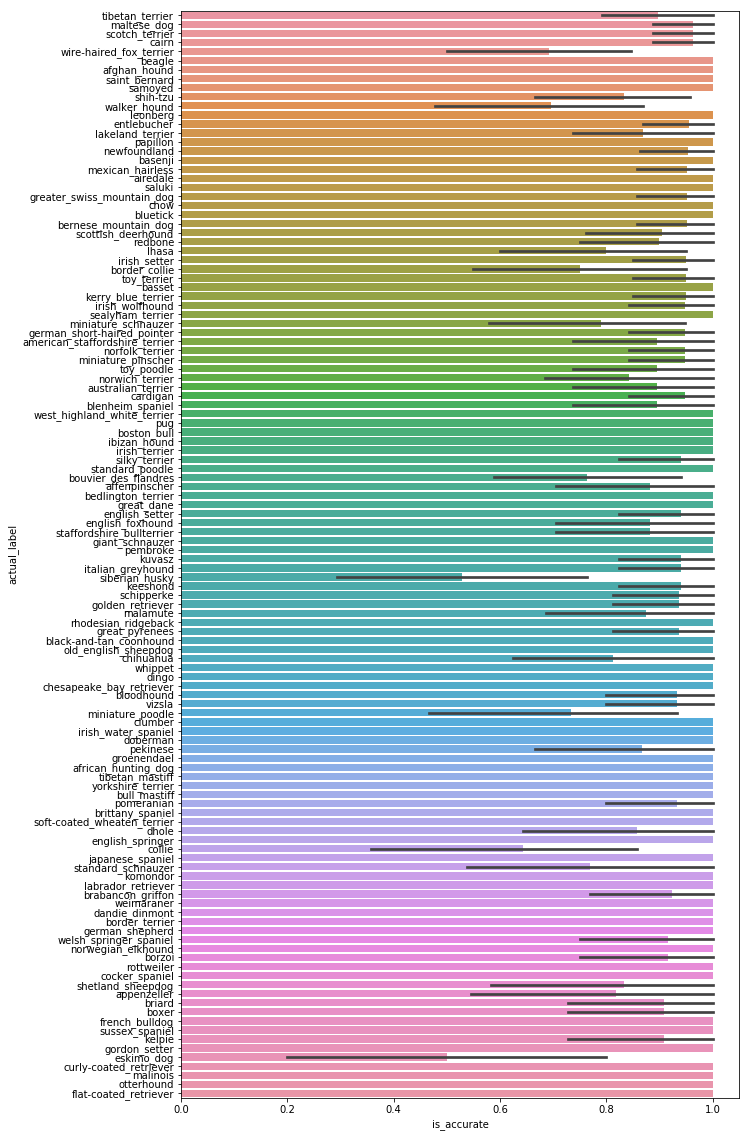

In [69]:
fig, ax = plt.subplots(figsize=(10, 20))

sns.barplot(
    x='is_accurate',
    y='actual_label',
    data=pred_vs_act_val,
    order=pred_vs_act_val['actual_label'].value_counts().index,
    ax=ax)